In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


df = pd.read_csv("../data/ReviewsWithVotes.csv")

# fix votes nan to 0
df["votes"] = df["votes"].fillna(1)
df["votes"] = df["votes"] - 1 # remove self votes

# normalize votes
df["votes"] = df["votes"] / df["votes"].max()


high_quality_threshold = 0.45

df["imputed_quality"] = (df["votes"] >= high_quality_threshold)*1


# convert boolean cols to int
df["again"] = df["again"].astype(int)
df["instructorEnjoyed"] = df["instructorEnjoyed"].astype(int)
df["instructorAgain"] = df["instructorAgain"].astype(int)




def get_vectorizer(df, text_column):
    """
    Vectorize the text column
    """
    vect = TfidfVectorizer(
        max_features=1000,
        max_df=0.8,
        min_df=0.1,
        stop_words="english",
    )
    vect.fit_transform(df[text_column])
    return vect






In [3]:
df["imputed_quality"].value_counts()

0    1638
1     287
Name: imputed_quality, dtype: int64

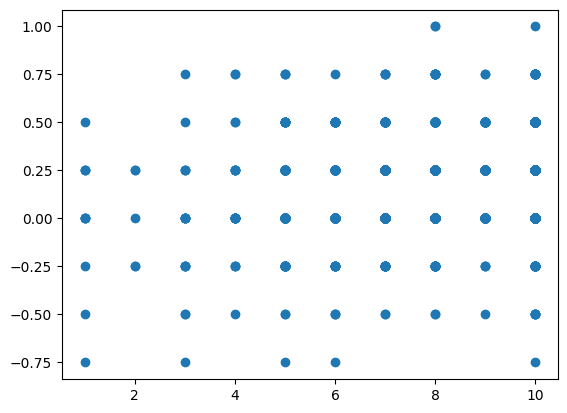

In [4]:
import matplotlib.pyplot as plt

# plt.hist(df["votes"], bins=6)


plt.scatter(df["instructorEnthusiasm"], df["votes"]) # these won't work



In [5]:
high_quality_df = df[df["imputed_quality"] == 1]


v = get_vectorizer(high_quality_df, "content")


X = v.transform(high_quality_df["content"])

v.get_feature_names_out()



array(['assignments', 'class', 'classes', 'course', 'definitely', 'did',
       'difficult', 'does', 'easy', 'engaging', 'enjoyed', 'exams',
       'experience', 'extremely', 'fair', 'final', 'fun', 'good', 'great',
       'homework', 'hours', 'interested', 'interesting', 'learn',
       'learned', 'learning', 'lecture', 'lectures', 'like', 'little',
       'long', 'lot', 'material', 'overall', 'papers', 'passionate',
       'pretty', 'problem', 'prof', 'professor', 'questions', 'reading',
       'readings', 'really', 'recommend', 'semester', 'sets', 'students',
       'super', 'taking', 'teaching', 'time', 'understanding', 'way',
       'week', 'work'], dtype=object)

In [6]:
# y = df["imputed_quality"]

# x_df = pd.DataFrame(X.toarray(), columns=v.get_feature_names_out())
# # x_df["imputed_quality"] = labels

# from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.15)

# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(penalty="l2")
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

# print(classification_report(y_test, y_pred))







In [7]:
sliders = [
    "rating",
    "difficulty",
    "value",
    "instructorEffectiveness",
    "instructorAccommodationLevel",
    "instructorEnthusiasm",
]

def get_default_slider_mse(row):
    return np.mean((row[sliders] - 5)**2)

df["default_mse"] = df.apply(get_default_slider_mse, axis=1)

In [8]:
def get_review_content_length(row):
    return (len(row["content"]) - 200)/200

df["content_length"] = df.apply(get_review_content_length, axis=1)


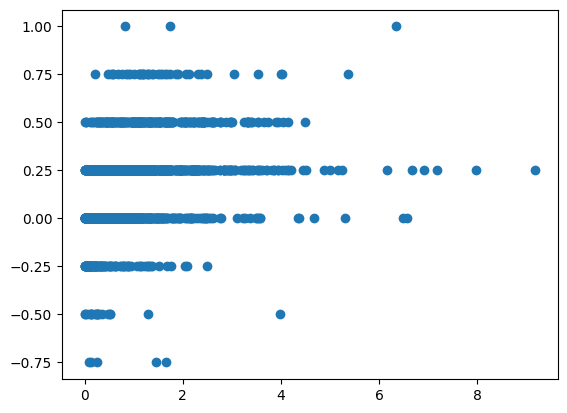

In [9]:
plt.figure()


plt.scatter(df["content_length"], df["votes"])

plt.show()

In [10]:
def get_average_sentence_length(row):
    return len(row["content"].split(" ")) / len(row["content"].split("."))


df["average_sentence_length"] = df.apply(get_average_sentence_length, axis=1)

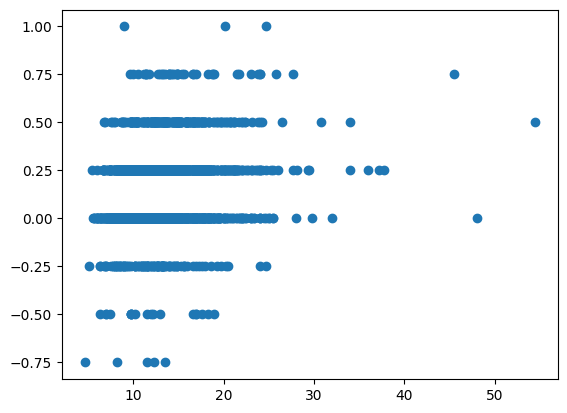

In [11]:
plt.figure()

plt.scatter(df["average_sentence_length"], df["votes"])

plt.show()

In [23]:
slider_cols = ["value", "difficulty", "rating", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel"]

def get_variance(vals):
    return np.var(vals)

columns = ["value", "difficulty", "rating", "again", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel", "instructorEnjoyed", "instructorAgain"]


default_slider_vals = {
    "value": 5,
    "difficulty": 5,
    "rating": 5,
    "again": 0,
    "instructorEffectiveness": 5,
    "instructorEnthusiasm": 5,
    "instructorAccommodationLevel": 5,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_negative_vals = {
    "value": 1,
    "difficulty": 10,
    "rating": 1,
    "again": 0,
    "instructorEffectiveness": 1,
    "instructorEnthusiasm": 1,
    "instructorAccommodationLevel": 1,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_positive_vals = {
    "value": 10,
    "difficulty": 1,
    "rating": 10,
    "again": 1,
    "instructorEffectiveness": 10,
    "instructorEnthusiasm": 10,
    "instructorAccommodationLevel": 10,
    "instructorEnjoyed": 1,
    "instructorAgain": 1
}

default_slider_vals_list = [default_slider_vals[col] for col in columns]
overly_negative_vals_list = [overly_negative_vals[col] for col in columns]
overly_positive_vals_list = [overly_positive_vals[col] for col in columns]

def get_mse(vals, expected_vals):
    return np.mean(np.square(vals-expected_vals))


In [25]:
df["default_mse"] = df[columns].apply(get_mse, axis=1, args=(default_slider_vals_list,))
df["overly_negative_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_negative_vals_list,))
df["overly_positive_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_positive_vals_list,))

df["slider_variance"] = df[slider_cols].apply(get_variance, axis=1)

In [12]:
# readability
# from readability import flesch_reading_ease, smog_index, dale_chall_readability_score

from textstat.textstat import textstatistics
import math


flesch_reading_ease = lambda x: textstatistics().flesch_reading_ease(x)
smog_index = lambda x: textstatistics().smog_index(x)
dale_chall_readability_score = lambda x: textstatistics().dale_chall_readability_score(x)

def get_fre_readability_score(row):
    return flesch_reading_ease(row["content"])

def get_smog_readability_score(row):
    return smog_index(row["content"])

def get_dale_chall_readability_score(row):
    return dale_chall_readability_score(row["content"])

df["fre_readability"] = df.apply(get_fre_readability_score, axis=1)
df["smog_readability"] = df.apply(get_smog_readability_score, axis=1)
df["dale_chall_readability"] = df.apply(get_dale_chall_readability_score, axis=1)


In [13]:
import math

def char_freq(text: str):
    """Calculates the frequency of each character in the text"""
    freq = {}
    for char in text:
        freq[char] = freq.get(char, 0) + 1
    return freq

def shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text)
    freq = char_freq(text)

    entropy = 0
    for char in freq:
        prob = freq[char] / length
        entropy -= prob * math.log(prob, 2)

    return entropy


def get_review_entropy(row):
    return shannon_entropy(row["content"])

df["entropy"] = df.apply(get_review_entropy, axis=1)

In [38]:
def word_freq(text: str):
    """Calculates the frequency of each word in the text"""
    freq = {}
    for word in text.split(" "):
        freq[word] = freq.get(word, 0) + 1
    return freq

def word_shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text.split(" "))
    freq = word_freq(text)

    entropy = 0
    for word in freq:
        prob = freq[word] / length
        entropy -= prob * math.log(prob, 2)

    return entropy

def get_review_word_entropy(row):
    return word_shannon_entropy(row["content"].lower())

df["word_entropy"] = df.apply(get_review_word_entropy, axis=1)
df["word_diversity"] = df["word_entropy"] / df["content_length"] #this can create inf
df["word_diversity"] = df["word_diversity"].replace([np.inf, -np.inf], np.nan)
df["word_diversity"] = df["word_diversity"].fillna(df["word_diversity"].max())

In [29]:
from datetime import datetime, date, timedelta

def convert_term_string_to_date(term):
    # F22 -> 2022-09-01
    # S21 -> 2021-02-01
    # W21 -> 2021-01-01

    year = int(term[1:3])
    year = 2000 + year #Y2K baby!
    
    t_obj = {
        "F": date(year, 9, 1),
        "S": date(year, 2, 1),
        "W": date(year, 1, 1)
    }

    return t_obj[term[0]]



def time_between_course_and_review(row):
    # example reviewDate: 2022-10-24 03:16:49.083+00
    # only care aoout the date, not the time
    format = "%Y-%m-%d"
    time_string = row["reviewDate"]
    course_date = convert_term_string_to_date(row["semester"])

    date_string = time_string.split(" ")[0]


    review_date = datetime.strptime(date_string, format).date()

    return ((review_date - course_date).days) / 365



In [30]:
df["time_between_course_and_review"] = df.apply(time_between_course_and_review, axis=1)

In [55]:
# Sentiment Analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(row):
    return analyser.polarity_scores(row["content"])["compound"]

def get_neutrality_scores(row):
    return analyser.polarity_scores(row["content"])["neu"]

df["sentiment_scores"] = df.apply(get_sentiment_scores, axis=1)
df["neutrality_scores"] = df.apply(get_neutrality_scores, axis=1)

In [49]:
# Polarity
# a measure of if sentiment matches the ratings

def get_consistent_polarity(row):
    same_sign = 1 if row["sentiment_scores"] * (row["rating"]-5) > 0 else 0
    magnitude_threshold = 0.2
    same_magnitude = 1 if (abs(row["sentiment_scores"]) - abs(row["rating"]/10)) < magnitude_threshold else 0
    return same_sign * same_magnitude

def get_polarity(row):
    return row["sentiment_scores"] - ((row["rating"]-5)/10)

df["consistent_polarity"] = df.apply(get_consistent_polarity, axis=1)
df["polarity"] = df.apply(get_polarity, axis=1)

In [77]:
# KNN avg distance to nearest neighbor

from sklearn.neighbors import NearestNeighbors
import math

k = 5

def get_knn_avg_distance(df, row):

    X = df[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()])
    return distances[0].mean()



def get_knn_same_course_avg_distance(df, row):

    columns = [
        "rating",
        "difficulty",
        "value",
        "hours",
        "again",
        
        "default_mse",
        "content_length",
        "sentiment_scores",
    ]

    courseID = row["courseID"]
    X = df[df["courseID"] == courseID][columns].to_numpy()

    n_neighbors = min(k, len(X))

    if n_neighbors == 0:
        return math.nan

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[columns].to_numpy()])

    return distances[0].mean()




df["knn_avg_distance"] = df.apply(lambda row: get_knn_avg_distance(df, row), axis=1)
df["knn_same_course_avg_distance"] = df.apply(lambda row: get_knn_same_course_avg_distance(df, row), axis=1)

# replace knn_same_course_avg_distance with avg if nan or inf
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].replace([np.inf, -np.inf], np.nan)
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].fillna(df["knn_same_course_avg_distance"].mean())




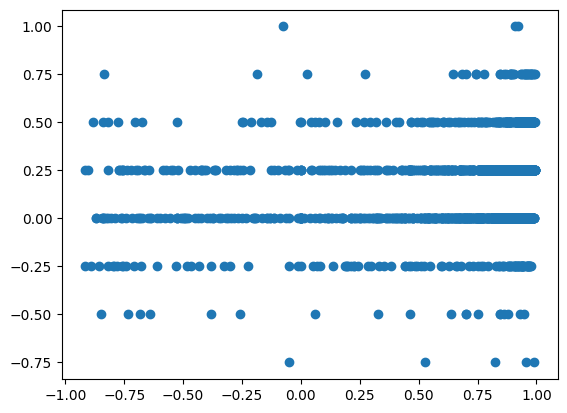

In [57]:
# sentiment_scores

plt.figure()

plt.scatter(df["sentiment_scores"], df["votes"])

plt.show()

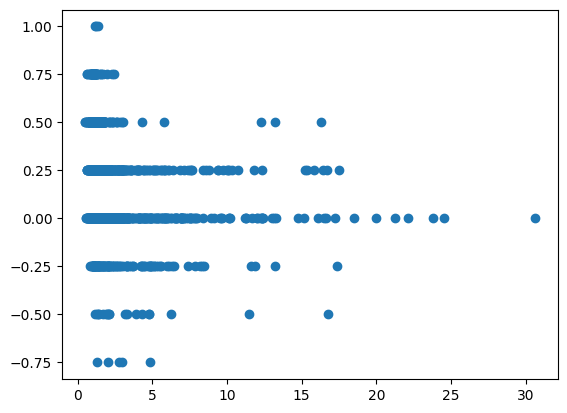

In [79]:
# entropy

plt.figure()

plt.scatter(df["knn_avg_distance"], df["votes"])

plt.show()

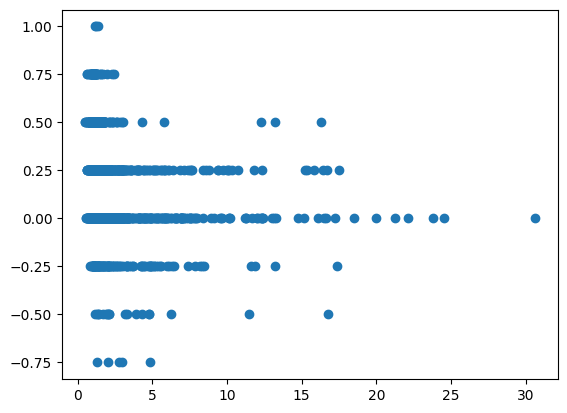

In [68]:
# entropy

plt.figure()

plt.scatter(df["entropy"], df["votes"])

plt.show()

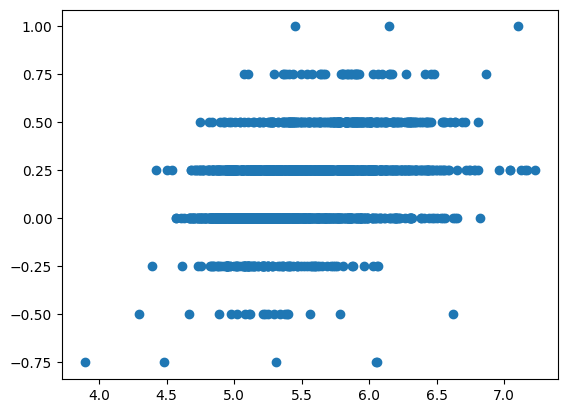

In [16]:
# word entropy

plt.figure()

plt.scatter(df["word_entropy"], df["votes"])

plt.show()

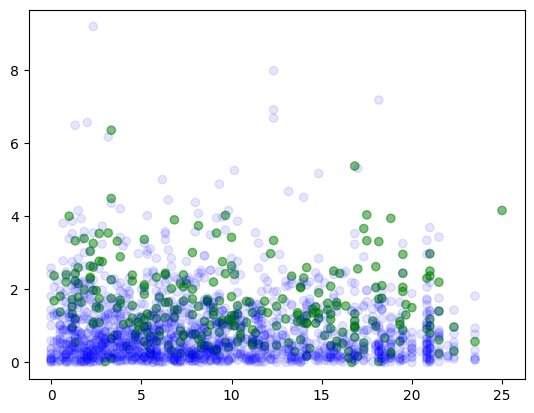

In [17]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

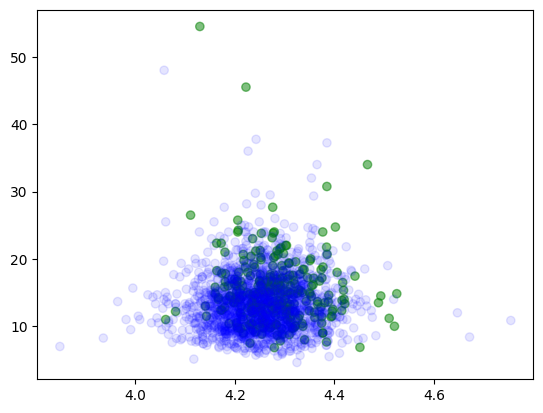

In [18]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["entropy"], df["average_sentence_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

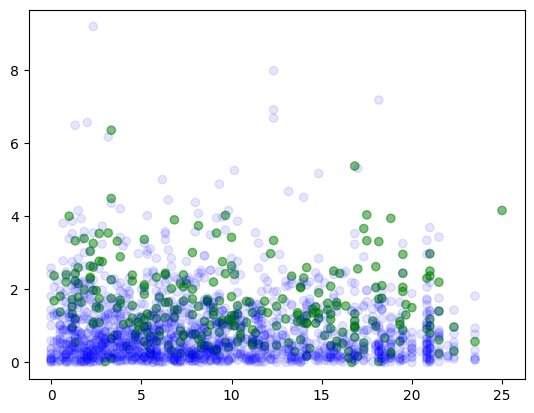

In [19]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

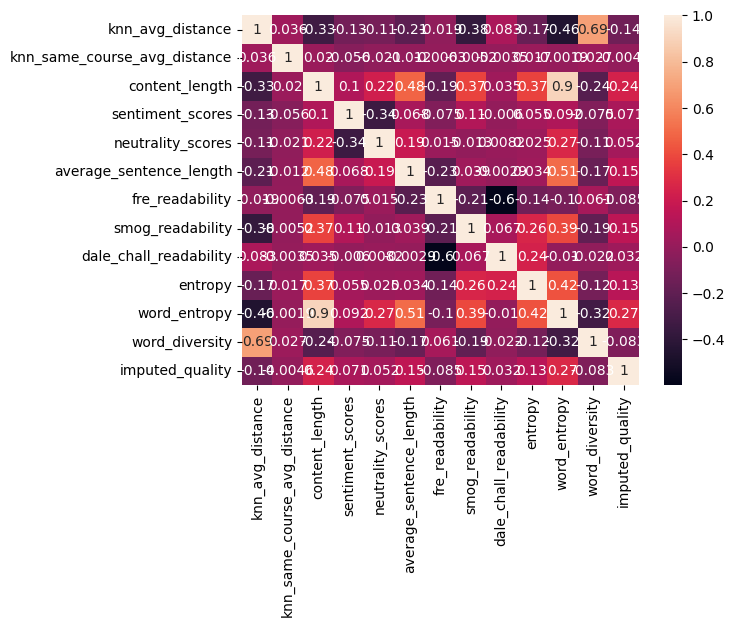

In [80]:
# cor
import seaborn as sns

corr_features = [
    # "default_mse",
    # "overly_negative_mse",
    # "overly_positive_mse",
    # "slider_variance",
    # "time_between_course_and_review",

    "knn_avg_distance",
    

    "content_length",
    "sentiment_scores",
    "neutrality_scores",
    
    # "polarity",
    # "consistent_polarity",
    
    "average_sentence_length",
    "fre_readability",
    "smog_readability",
    "dale_chall_readability",
    "entropy",
    "word_entropy",
    "word_diversity",

]

corr_features.append("imputed_quality")

plt.figure()

sns.heatmap(df[corr_features].corr(), annot=True)
            
plt.show()

In [81]:
# LR

# this is cheating!! since we are training the model while we are deciding which features to use

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_words = v.transform(df["content"])
X_words_row_sum = X_words.sum(axis=1)
X = df[corr_features[:-1]]

X = np.concatenate((X, X_words.toarray()), axis=1)
X = np.concatenate((X, X_words_row_sum), axis=1)



y = df["imputed_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

lr = LogisticRegression(max_iter=100000, class_weight="balanced", penalty="l2")

lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))


print("RF ------------------------------")

# RF

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", max_depth=5)

rf.fit(X_train, y_train)

print(rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: Future

0.657439446366782
              precision    recall  f1-score   support

           0       0.91      0.66      0.77       246
           1       0.25      0.63      0.35        43

    accuracy                           0.66       289
   macro avg       0.58      0.65      0.56       289
weighted avg       0.81      0.66      0.71       289

RF ------------------------------
0.6608996539792388
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       246
           1       0.23      0.56      0.33        43

    accuracy                           0.66       289
   macro avg       0.57      0.62      0.55       289
weighted avg       0.80      0.66      0.71       289



c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [72]:
print(lr.coef_)

[[-0.10832477 -0.27652526  0.2775384   0.82798496 -0.01285724 -0.00825796
   0.01683819  0.10638291  0.37121701  1.85074505 -0.00448439  0.82611372
  -0.04827418  0.36421775 -0.4302389  -0.26627771 -0.17886088 -0.66049874
   0.7763087  -0.41654492 -0.85108397 -0.08881619  0.48827603  0.58150686
   0.26223762  0.86934227 -1.06794356  0.54207706 -0.12374502  0.26773838
   0.64737991 -0.54406452  0.42968209  0.61884206  0.73178006  0.41400313
  -0.16895997  0.62953049  0.12799763 -0.21093284  0.30482327  0.14698615
   0.01961993  0.06266734 -0.97392308 -0.4599843   0.18033386 -0.30988733
   1.02546738  0.10262645 -0.29501265  0.24383867 -0.30469541 -1.41374338
  -0.13530211  0.3534417  -1.43377207  0.42298775  0.50996008  0.06298733
   0.3901307   0.02883271 -1.30659259  0.43715037 -0.08733441 -0.7976742
   0.19169769  0.48642225]]
